# Customer Segmentation RFM Kmean Cluster and Recommendations
## Business Problem: 
### An e-commerce company is facing challenges in optimizing its marketing and customer retention strategies. While some customers appear highly engaged, others show signs of reduced activity or are at risk of disengagement. Currently, the company employs a one-size-fits-all approach to customer engagement, which results in inefficiencies in marketing spend and missed opportunities to maximize customer lifetime value.

### To address this issue, the company aims to segment its customer base based on behavioral and transactional data (such as purchase frequency, recency of orders, and monetary value). By identifying distinct customer segments, the company intends to develop targeted marketing strategies that cater to the unique needs and behaviors of each group.
 

## Table of Contents
1. Setup Kaggle API
2. Data Cleansing
3. Exploratory Analysis
4. Data Transformation (RFM)
5. Unsupervised Learning - Kmeans
6. Conclusion

## 1. Setup Kaggle API

In [4]:
##!pip install kaggle
## Create the .kaggle directory
##!mkdir C:\Users\juewa\.kaggle
#!dir C:\Users\juewa\.ipynb_checkpoints
#!kaggle datasets list
#download dataset
#!kaggle datasets download -d carrie1/ecommerce-data

In [6]:
#!pip install geopandas
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Cleansing
- Loading dataset: Number of raw records: 541909 
- Handling missing values: data = raw_data.dropna(subset=['CustomerID', 'Description'])
- Change data types
- Removing duplicates data = data.drop_duplicates()
- After handling missing values and removing duplicates we are left with 401604 records

In [8]:
# Unzip the downloaded file
with zipfile.ZipFile('ecommerce-data.zip', 'r') as zip_ref:
    zip_ref.extractall('ecommerce_data')

# Load the CSV file into a pandas DataFrame
raw_data = pd.read_csv('ecommerce_data/data.csv', encoding='ISO-8859-1')

print(f"Number of raw records: {len(raw_data)}")

Number of raw records: 541909


In [9]:
# Check for missing values
raw_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are total 541909 records, of which 1454 records were missing in Description, and 135080 records were missing in CustomerID

Removing rows with missing values in 'Description' and 'CustomerID' due to:
 1. Missing values prevent meaningful insights. 
 2. Keeping rows with missing values could skew analysis and lead to biased results.

Removing them allows you to focus on more relevant and complete data for the analysis, avoiding noise or unnecessary complications

In [12]:
# Remove missing values
data = raw_data.dropna(subset=['CustomerID', 'Description'])
print(f"Number of records after handling missing values: {len(data)}")

Number of records after handling missing values: 406829


In [13]:
# Convert data type
# Use .loc[] to safely modify the DataFrame
data.loc[:, 'InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])  # Convert 'InvoiceDate' to datetime
data.loc[:, ['InvoiceNo', 'StockCode', 'CustomerID', 'Country']] = data[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].astype(str)  # Convert multiple columns to string
data.loc[:, ['Quantity', 'UnitPrice']] = data[['Quantity', 'UnitPrice']].apply(pd.to_numeric, errors='coerce')  # Convert to numeric

#Check data types
data.dtypes

C:\Users\juewa\AppData\Local\Temp\ipykernel_24496\2410284339.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['17850.0' '17850.0' '17850.0' ... '12680.0' '12680.0' '12680.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[:, ['InvoiceNo', 'StockCode', 'CustomerID', 'Country']] = data[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].astype(str)  # Convert multiple columns to string


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [42]:
# Remove duplicate rows from the DataFrame
data = data.drop_duplicates()
data['Total_Price']=data['Quantity']*data['UnitPrice']

# Check if duplicates have been removed
print(f"Number of rows after removing duplicates: {len(data)}")
data.head()

Number of rows after removing duplicates: 401604


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Pricce,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34


After handling missing values and removing duplicates we are left with 401604 records

## 3. Exploratory Data Analysis

### 3.1 Country: There are 37 unique countries where revenue is largely dominated from the UK.

In [47]:
# Group by 'Country' and aggregate the necessary columns
table = data.groupby('Country').agg(
    Unique_Invoices=('InvoiceNo', 'nunique'),
    Total_Customers=('CustomerID', 'nunique'),
    StockCode_Count=('StockCode', 'nunique'),
    Total_Quantity=('Quantity', 'sum'),
    Total_Price=('UnitPrice', lambda x: sum(x * data.loc[x.index, 'Quantity']))
).reset_index().sort_values(by='Total_Price', ascending=False)

# Display the resulting table
table.head()
           

,Country,Unique_Invoices,Total_Customers,StockCode_Count,Total_Quantity,Total_Price
35,United Kingdom,19857,3950,3661,3994870,6747156.154
23,Netherlands,101,9,785,200128,284661.540
10,EIRE,319,3,1950,136187,250001.780
14,Germany,603,95,1671,117341,221509.470
13,France,458,87,1523,109806,196626.050


In [49]:
print(f"Number of unique countries: {table['Country'].nunique()}")

Number of unique countries: 37


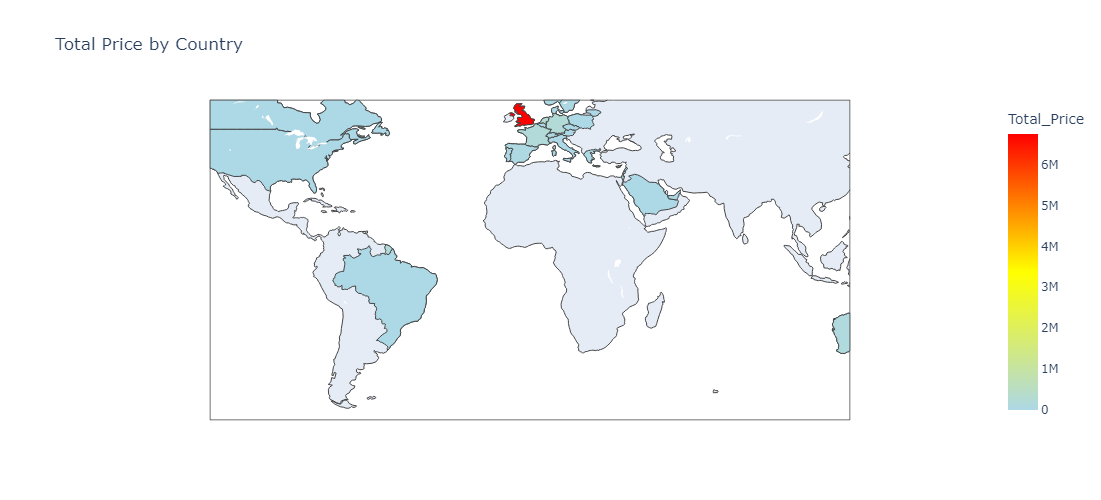

In [53]:
# Group by 'Country' and count unique 'InvoiceNo' for each country
temp = table.groupby('Country').agg({'Total_Price': 'sum'}).reset_index()

# Rename columns for clarity
temp.columns = ['Country', 'Total_Price']

import plotly.express as px

# Create a choropleth map
fig = px.choropleth(temp, 
                    locations="Country", 
                    locationmode='country names', 
                    color="Total_Price", 
                    hover_name="Country", 
                    color_continuous_scale=[[0, 'lightblue'], [0.5, 'yellow'], [1, 'red']],  # Custom color scale
                    title="Total Price by Country")
fig.update_layout(
    geo=dict(
        projection_scale=1.5  # Adjust projection scale for larger size
    ),
    width=1000,  # Set map width
    height=500   # Set map height
)
# Show the plot
fig.show()

### 3.2 To analyze the top 5 countries based on the following metrics, different spending habit by countries:

* Unique invoice counts for each country.
* Average invoice value per country.
* Number of unique customers from each country.
* Average amount spent per customer.

In [56]:
# Step 1: Group by country and calculate the necessary metrics
country_analysis = data.groupby('Country').agg(
    Unique_Invoices=('InvoiceNo', 'nunique'),           # Count of unique invoices
    Total_Customers=('CustomerID', 'nunique'),          # Count of unique customers
    Total_Price=('Total_Price', 'sum'),                  # Total price for each country
    Total_Quantity=('Quantity', 'sum')                  # Total quantity sold in each country
).reset_index()

# Step 2: Calculate additional metrics (average invoice value and average spending per customer)
country_analysis['Avg_Invoice_Value'] = country_analysis['Total_Price'] / country_analysis['Unique_Invoices']
country_analysis['Avg_Spending_per_Customer'] = country_analysis['Total_Price'] / country_analysis['Total_Customers']

# Step 3: Sort the data by 'Unique_Invoices' to get the top 5 countries by number of unique invoices
top_5_countries = country_analysis.sort_values(by='Unique_Invoices', ascending=False).head(5)

# Step 4: Format the Avg_Invoice_Value and Avg_Spending_per_Customer with $ and 2 decimal places
top_5_countries['Avg_Invoice_Value'] = top_5_countries['Avg_Invoice_Value'].apply(lambda x: f"${x:,.2f}")
top_5_countries['Avg_Spending_per_Customer'] = top_5_countries['Avg_Spending_per_Customer'].apply(lambda x: f"${x:,.2f}")

# Display the result with formatted columns
top_5_countries[['Country', 'Unique_Invoices', 'Total_Customers', 'Avg_Invoice_Value', 'Avg_Spending_per_Customer']]




,Country,Unique_Invoices,Total_Customers,Avg_Invoice_Value,Avg_Spending_per_Customer
35,United Kingdom,19857,3950,$339.79,"$1,708.14"
14,Germany,603,95,$367.35,"$2,331.68"
13,France,458,87,$429.31,"$2,260.07"
10,EIRE,319,3,$783.70,"$83,333.93"
3,Belgium,119,25,$343.79,"$1,636.44"


## 4. Data Transformation (RFM)
To reduce noice, we will focus on UK for country specific RFM customer segmentation, with 3950 unique customers

In [59]:
# Filter the data for 'UK' only
uk_data = data[data['Country'] == 'United Kingdom']

# Display the result
uk_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Pricce,Total_Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34


### Determine the latest invoice date as the current date and subtract the last purchasing date of each customer from this date.

In [62]:
# Get the minimum and maximum billing dates (InvoiceDate)
min_billing_date = uk_data['InvoiceDate'].min()
max_billing_date = uk_data['InvoiceDate'].max()

# Display the results
print(f"Min Billing Date: {min_billing_date}")
print(f"Max Billing Date: {max_billing_date}")

Min Billing Date: 2010-12-01 08:26:00
Max Billing Date: 2011-12-09 12:49:00


In [66]:
# Ensure 'InvoiceDate' is in datetime format
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

# Define a snapshot date (the latest date in the dataset)
snapshot_date = uk_data['InvoiceDate'].max() + pd.DateOffset(days=1)

# Group by CustomerID and calculate RFM metrics
rfm = uk_data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),  # Recency: Days since last purchase
    Frequency=('InvoiceNo', 'nunique'),                                 # Frequency: Number of unique invoices
    Monetary=('Total_Price', 'sum')                                      # Monetary: Total spending
).reset_index()

# Display the RFM table
print(rfm.head())
print(rfm.shape[0])

  CustomerID  Recency  Frequency  Monetary
0    12346.0      326          2      0.00
1    12747.0        2         11   4196.01
2    12748.0        1        224  28405.56
3    12749.0        4          8   3868.20
4    12820.0        3          4    942.34
3950


C:\Users\juewa\AppData\Local\Temp\ipykernel_24496\3797950796.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 5. Unsupervised Clustering

In [69]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Let's now scale the data
* To keep uniform scales since Monetary value usually has a larger range

In [72]:
# Step 1: Keep CustomerID aside and only scale the RFM values
customer_ids = rfm['CustomerID']  # Keep CustomerID intact
rfm_values = rfm[['Recency', 'Frequency', 'Monetary']]  # Only scale the RFM values

# Step 2: Scale the RFM values (Recency, Frequency, and Monetary)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_values)  # Scale only the RFM columns

# Step 3: Create a DataFrame for the scaled RFM values
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'])

# Step 4: Add CustomerID back to the scaled DataFrame
rfm_scaled_df['CustomerID'] = customer_ids.reset_index(drop=True)

# Display the first few rows of the scaled DataFrame
rfm_scaled_df.head()

,Recency_Scaled,Frequency_Scaled,Monetary_Scaled,CustomerID
0,2.337128,-0.347294,-0.260860,12346.0
1,-0.895835,0.685265,0.379937,12747.0
2,-0.905813,25.122514,4.077120,12748.0
3,-0.875878,0.341079,0.329875,12749.0
4,-0.885857,-0.117837,-0.116950,12820.0


In [74]:
print(rfm_scaled)

[[ 2.33712818e+00 -3.47294453e-01 -2.60860257e-01]
 [-8.95834929e-01  6.85265369e-01  3.79937181e-01]
 [-9.05813210e-01  2.51225145e+01  4.07712036e+00]
 ...
 [-8.35965241e-01 -2.32565583e-01 -2.33890629e-01]
 [-8.75878366e-01  1.25890971e+00  5.15246951e-02]
 [-4.86725400e-01 -2.32565583e-01  1.97216092e-02]]


### Apply K-Means clustering

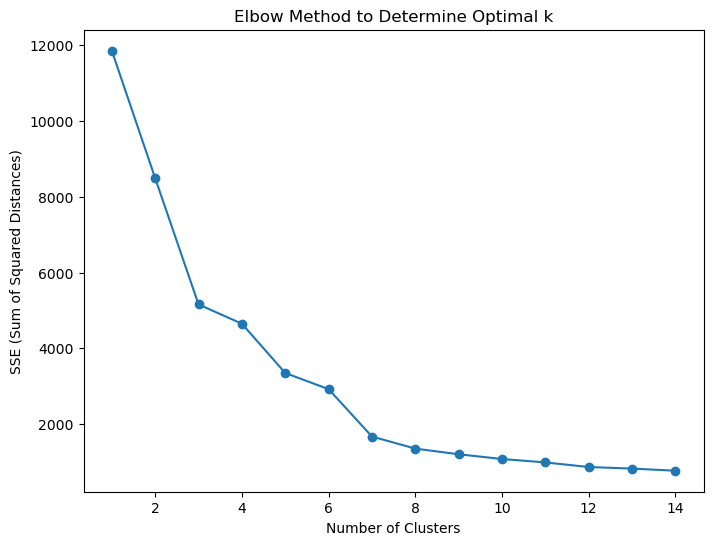

In [77]:
# Find the best number of clusters using the Elbow Method

# Function to plot the Elbow Method for KMeans
def plot_elbow_curve(data):
    sse = []
    k_range = range(1, 15)  # Testing from 1 to 10 clusters
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # Sum of squared distances to the closest cluster center
        
    # Plot the Elbow Curve
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE (Sum of Squared Distances)')
    plt.title('Elbow Method to Determine Optimal k')
    plt.show()

# Run the Elbow Method to determine the best number of clusters
plot_elbow_curve(rfm_scaled)

In [79]:
# From the graph above we can choose optimal_cluster= 6
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())
print(rfm_scaled_df.head())
print(rfm_scaled_df.shape[0])
print(rfm.shape[0])

  CustomerID  Recency  Frequency  Monetary  Cluster
0    12346.0      326          2      0.00        0
1    12747.0        2         11   4196.01        1
2    12748.0        1        224  28405.56        2
3    12749.0        4          8   3868.20        1
4    12820.0        3          4    942.34        1
   Recency_Scaled  Frequency_Scaled  Monetary_Scaled CustomerID  Cluster
0        2.337128         -0.347294        -0.260860    12346.0        0
1       -0.895835          0.685265         0.379937    12747.0        1
2       -0.905813         25.122514         4.077120    12748.0        2
3       -0.875878          0.341079         0.329875    12749.0        1
4       -0.885857         -0.117837        -0.116950    12820.0        1
3950
3950


### Cluster summary with Scaled RFM

In [82]:
# Now aggregate the clusters
cluster_summary_scaled = rfm_scaled_df.groupby('Cluster').agg({
    'Recency_Scaled': 'mean',
    'Frequency_Scaled': 'mean',
    'Monetary_Scaled': 'mean'
}).reset_index()

# Display the cluster summary
print("Cluster Summary (Scaled RFM):")
print(cluster_summary_scaled)

Cluster Summary (Scaled RFM):
   Cluster  Recency_Scaled  Frequency_Scaled  Monetary_Scaled
0        0        2.036823         -0.404970        -0.209801
1        1       -0.579298         -0.067649        -0.066527
2        2       -0.902487         19.347828         3.806878
3        3       -0.852852          6.315805        12.626368
4        4       -0.796103          2.403257         1.154751
5        5        0.647656         -0.301498        -0.167030


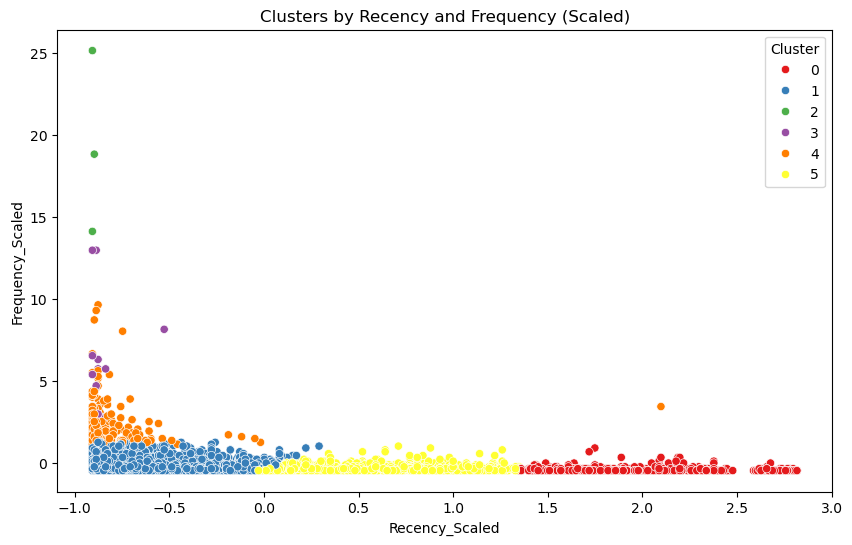

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency_Scaled', y='Frequency_Scaled', hue='Cluster', data=rfm_scaled_df, palette='Set1')
plt.title('Clusters by Recency and Frequency (Scaled)')
plt.show()

### Cluster Summary with Un-Scaled RFM

In [87]:
# Add the Cluster column to the raw RFM data
rfm['Cluster'] = rfm_scaled_df['Cluster']  # Assuming the cluster assignment is the same

# Perform aggregation on raw RFM data
cluster_summary_raw = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Display the raw RFM cluster summary
print("Cluster Summary (Raw RFM):")
print(cluster_summary_raw)

Cluster Summary (Raw RFM):
   Cluster     Recency   Frequency      Monetary
0        0  295.904159    1.497288    334.338210
1        1   33.722583    4.437449   1272.514079
2        2    1.333333  173.666667  26635.986667
3        3    6.307692   60.076923  84386.947692
4        4   11.994872   25.974359   9269.573744
5        5  156.685083    2.399171    614.409256


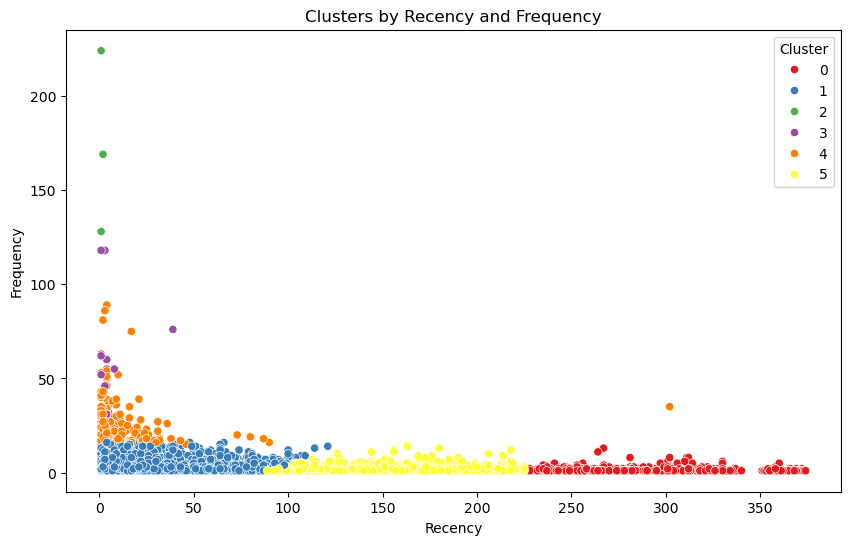

In [89]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm, palette='Set1')
plt.title('Clusters by Recency and Frequency')
plt.show()

### Pair Plot to Visualize Relationships:

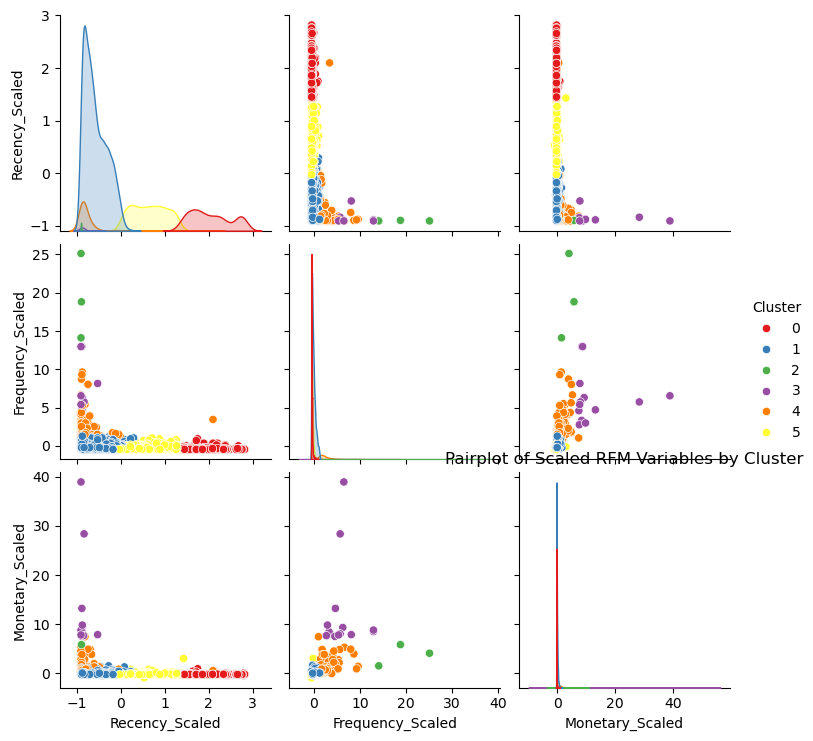

In [92]:
sns.pairplot(rfm_scaled_df, hue='Cluster', vars=['Recency_Scaled', 'Frequency_Scaled', 'Monetary_Scaled'], palette='Set1')
plt.title("Pairplot of Scaled RFM Variables by Cluster")
plt.show()

### Bar Plot of Mean RFM Values by Cluster:
Visualize the mean RFM values of each cluster using a bar plot to compare the clusters based on Recency, Frequency, and Monetary.

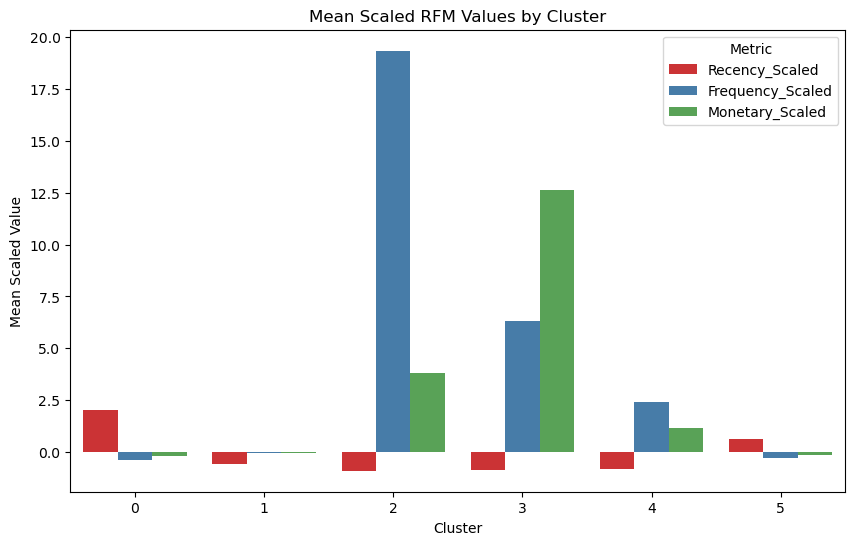

In [95]:
# Step 1: Group by Cluster and calculate the mean of the scaled RFM values
cluster_means_scaled = rfm_scaled_df.groupby('Cluster').agg({
    'Recency_Scaled': 'mean',
    'Frequency_Scaled': 'mean',
    'Monetary_Scaled': 'mean'
}).reset_index()

# Step 2: Melt the DataFrame for easy plotting (one column for Metric, one for Value)
cluster_means_melted = cluster_means_scaled.melt(id_vars='Cluster', var_name='Metric', value_name='Mean Value')

# Step 3: Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Mean Value', hue='Metric', data=cluster_means_melted, palette='Set1')
plt.title('Mean Scaled RFM Values by Cluster')
plt.ylabel('Mean Scaled Value')
plt.show()

## 6. Conclusion

C:\Users\juewa\AppData\Local\Temp\ipykernel_24496\2872382899.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




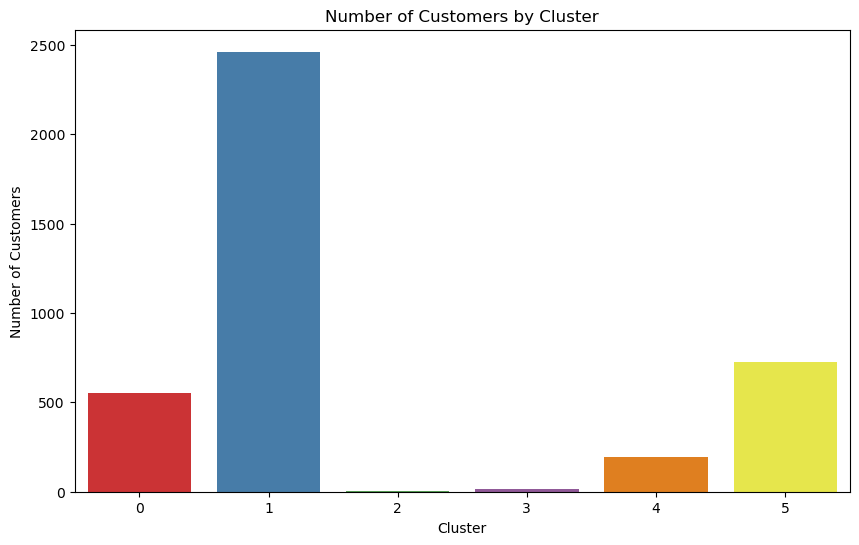

In [98]:
# Step 1: Count the number of customers in each cluster
customer_counts = rfm['Cluster'].value_counts().reset_index()
customer_counts.columns = ['Cluster', 'Number of Customers']

# Step 2: Create a bar plot to visualize the distribution of customers by cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Number of Customers', data=customer_counts, palette='Set1')
plt.title('Number of Customers by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

In [100]:
print("Cluster Summary (Raw RFM):")
print(cluster_summary_raw)

Cluster Summary (Raw RFM):
   Cluster     Recency   Frequency      Monetary
0        0  295.904159    1.497288    334.338210
1        1   33.722583    4.437449   1272.514079
2        2    1.333333  173.666667  26635.986667
3        3    6.307692   60.076923  84386.947692
4        4   11.994872   25.974359   9269.573744
5        5  156.685083    2.399171    614.409256


In [102]:
# Count the number of customers in each cluster
cluster_counts = rfm['Cluster'].value_counts().reset_index().sort_values(by='Cluster')
cluster_counts.columns = ['Cluster', 'Number of Customers']

# Display the cluster count
print(cluster_counts)

   Cluster  Number of Customers
2        0                  553
0        1                 2462
5        2                    3
4        3                   13
3        4                  195
1        5                  724


### Cluster Breakdown and Insights:
* **Cluster 0 (High Recency, Low Frequency, Low Monetary)**:

    - Recency (295.90 days): These customers haven't purchased in a long time.
    - Frequency (1.50 purchases): They rarely make purchases.
    - Monetary ($334.34): Their total spending is relatively low.
    - Conclusion: These are disengaged or at-risk customers. They have made very few purchases, haven’t bought recently, and contribute little to revenue. You might need to re-engage these customers with marketing or special offers.

* **Cluster 1 (Moderate Recency, Moderate Frequency, Moderate Monetary)**:

    - Recency (33.72 days): They have purchased recently.
    - Frequency (4.44 purchases): They buy occasionally, with moderate frequency.
    - Monetary ($1272.51): Their spending is moderate compared to other clusters.
    - Conclusion: These are active customers with regular but not frequent purchases. They are potentially valuable, and there’s an opportunity to increase their spending or frequency through targeted promotions.

* **Cluster 2 (Very Low Recency, Very High Frequency, Very High Monetary)**:

    - Recency (1.33 days): These customers made very recent purchases.
    - Frequency (173.67 purchases): Extremely high purchase frequency.
    - Monetary ($26,635.99): They spend a lot overall.
    - Conclusion: These are your most valuable customers. They buy frequently and spend a lot. This group should be treated as VIPs, and you should focus on retention strategies, loyalty rewards, or premium services to keep them engaged.

* **Cluster 3 (Low Recency, High Frequency, Extremely High Monetary)**:

    - Recency (6.31 days): They have also purchased recently.
    - Frequency (60.08 purchases): They make frequent purchases.
    - Monetary ($84,386.95): This group has the highest overall spending.
    - Conclusion: Another group of high-value customers. Although they don’t purchase as frequently as Cluster 2, their spending is significantly higher. They are likely high-ticket customers, and you should focus on retaining them by offering personalized or exclusive deals.

* **Cluster 4 (Moderate Recency, High Frequency, High Monetary)**:

    - Recency (11.99 days): They have made recent purchases.
    - Frequency (25.97 purchases): Their purchase frequency is high but lower than Clusters 2 and 3.
    - Monetary ($9,269.57): Their spending is high.
    - Conclusion: These are loyal, high-spending customers. They could be nurtured further with loyalty programs or upselling opportunities.

* **Cluster 5 (High Recency, Low Frequency, Low to Moderate Monetary)**:

    - Recency (156.69 days): They haven’t made a purchase in a while.
    - Frequency (2.40 purchases): They purchase infrequently.
    - Monetary ($614.41): Their spending is relatively low.
    - Conclusion: These customers are on the verge of becoming disengaged. They don’t buy frequently and haven’t done so recently. Re-engagement strategies, such as personalized offers or win-back campaigns, could be useful here.

### Recommendations:

* Reactivate or re-engage disengaged customers (Clusters 0 and 5) through tailored marketing and incentive campaigns.
* Nurture and increase the value of moderate-spending customers (Clusters 1 and 4) through upselling and loyalty programs.
* Sustain and improve engagement among top-tier, high-value customers (Clusters 2 and 3) by offering personalized, VIP-like experiences.